# Analyse fNIRS Data with MNE

In [1]:
%matplotlib inline

import mne
import os.path as op
import numpy as np
from mne.io import read_raw_nirx
import matplotlib.pyplot as plt
from itertools import compress

plt.rcParams["figure.figsize"] = (8,4)

## Read raw data exported directly from NIRx machine

In [2]:
raw = read_raw_nirx('tapping-P1', preload=True); 

Loading tapping-P1
Reading 0 ... 23238  =      0.000 ...  2974.464 secs...


Keep only the long channels / Discard short channels.

In [3]:
long_channels = ~mne.preprocessing._beer_lambert_law._short_channels(raw)
raw.pick(mne.pick_channels(raw.ch_names, list(compress(raw.ch_names, long_channels))))

<RawNIRX  |  tapping-P1, n_channels x n_times : 40 x 23239 (2974.5 sec), ~7.2 MB, data loaded>

### View raw data

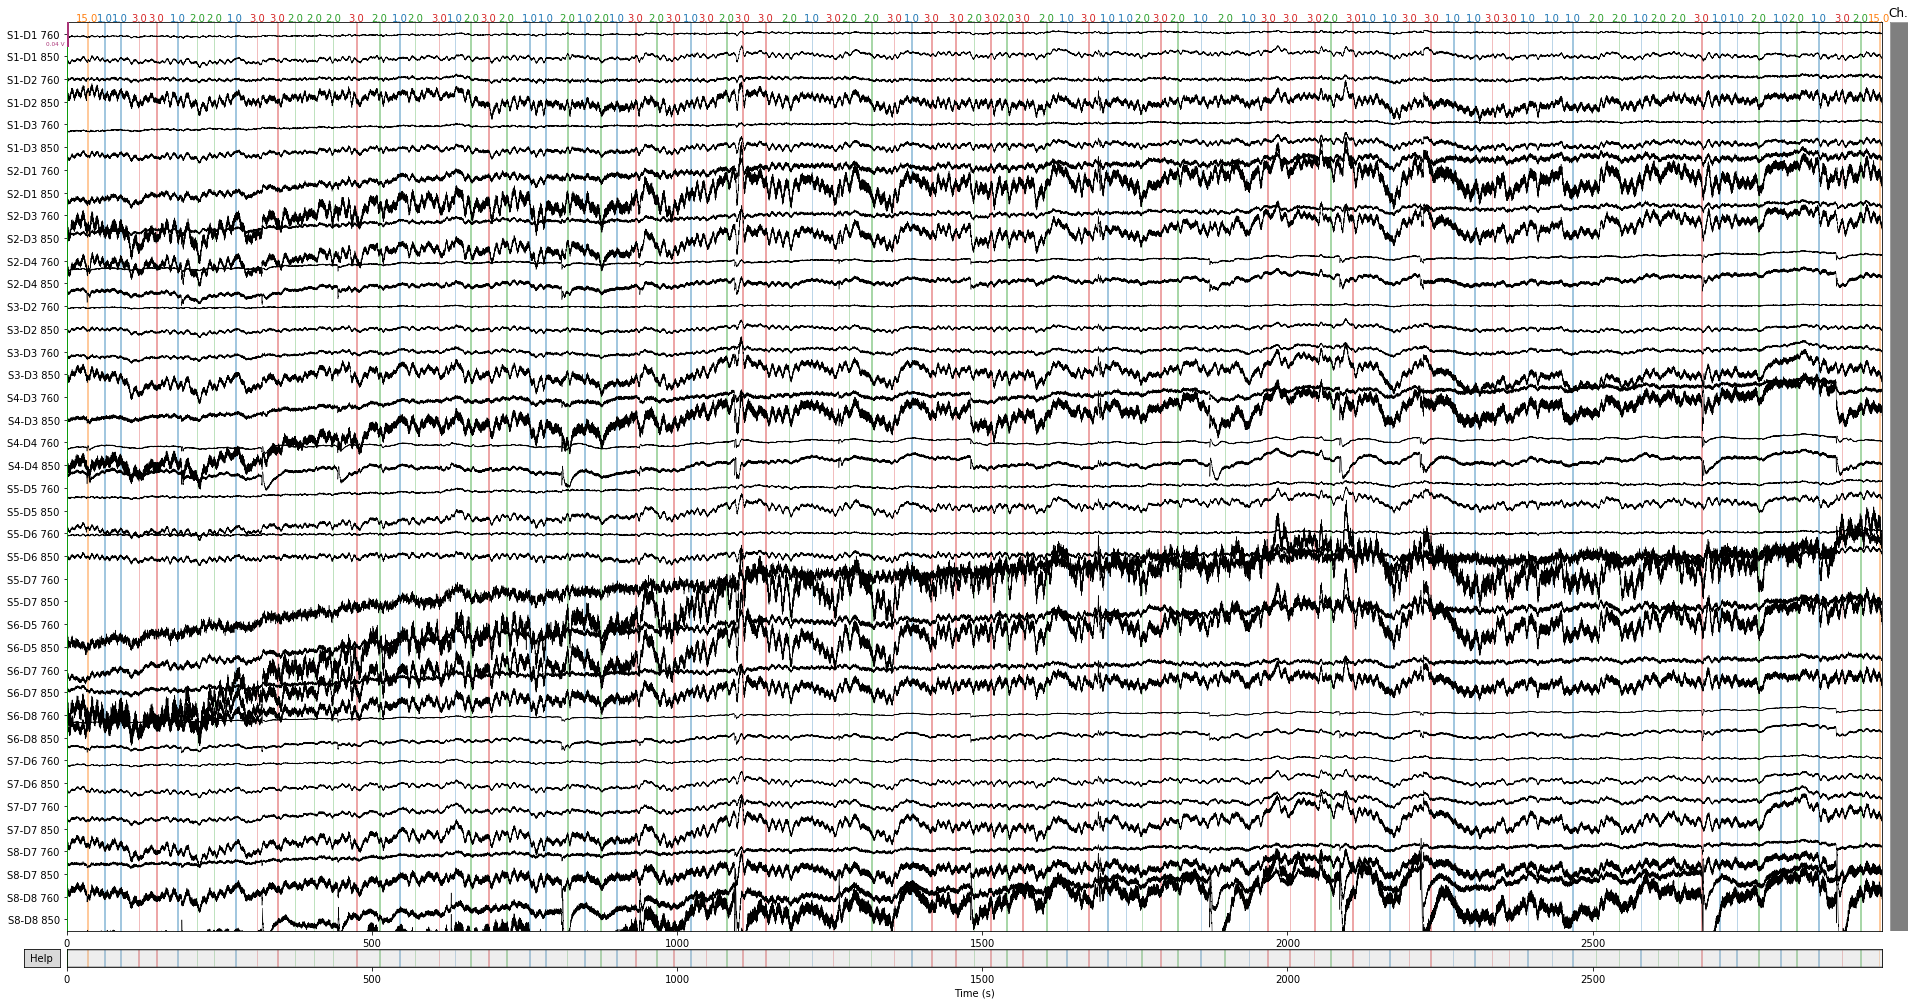

In [4]:
raw.plot(duration=1e10, start=0, n_channels = len(raw.ch_names));

In [5]:
raw = mne.preprocessing.optical_density(raw)
raw = mne.preprocessing.beer_lambert_law(raw)

Effective window size : 262.144 (s)
Effective window size : 262.144 (s)


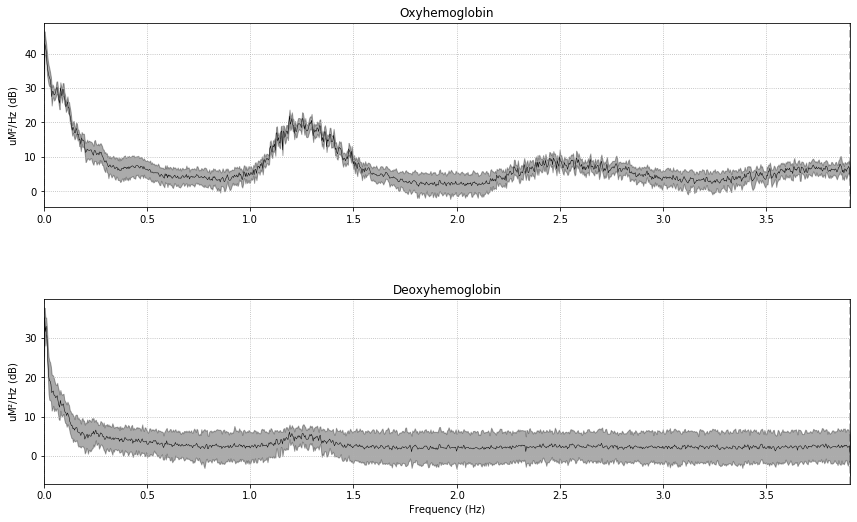

In [6]:
plt.rcParams["figure.figsize"] = (14,8)
raw.plot_psd(average=True);

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.012 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 2579 samples (330.112 sec)

Effective window size : 262.144 (s)
Effective window size : 262.144 (s)


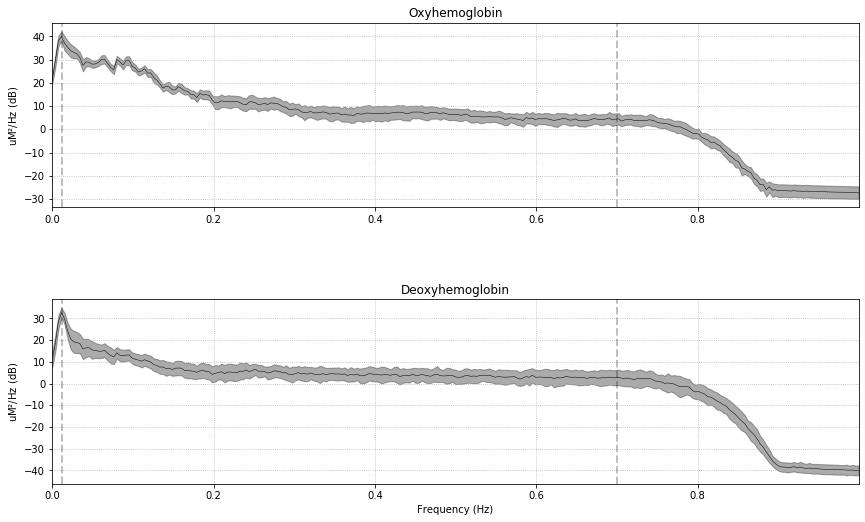

In [7]:
raw = raw.filter(0.012, 0.7, h_trans_bandwidth = 0.2, l_trans_bandwidth = 0.01)
raw.plot_psd(average=True, fmax = 1);


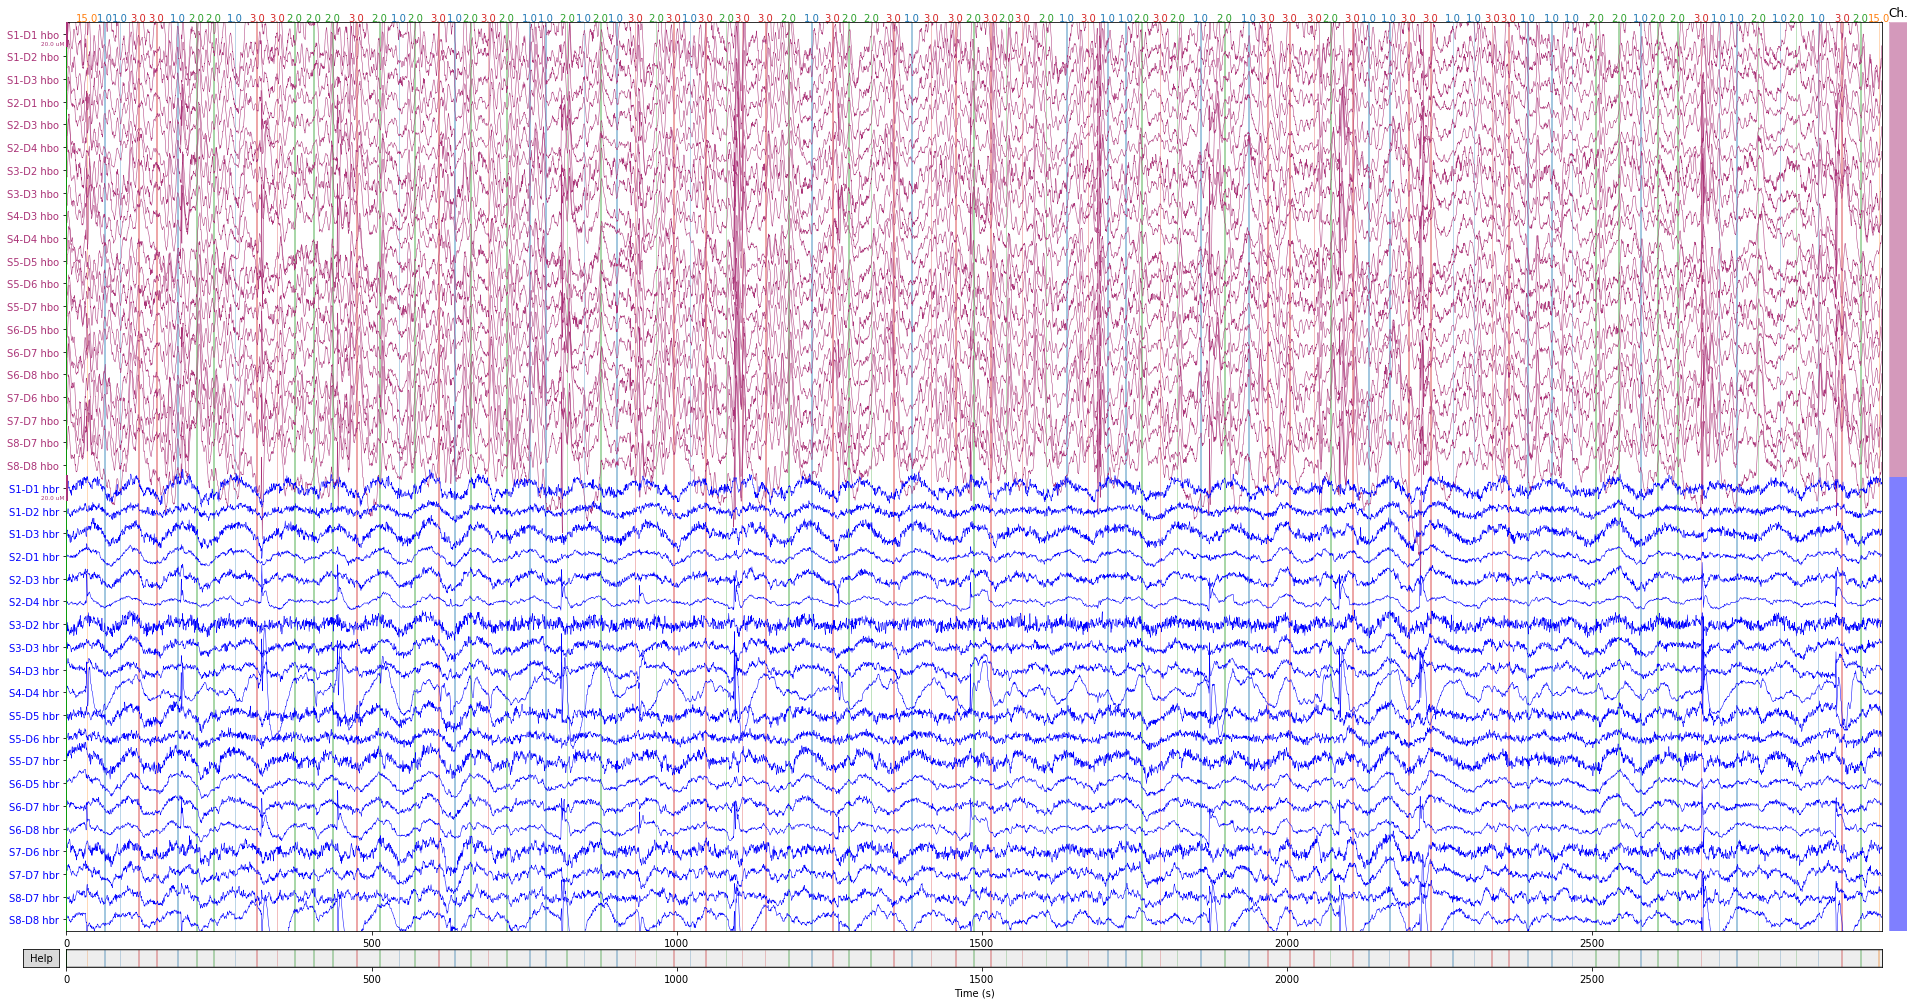

In [8]:
raw.plot(duration=1e10, start=0, n_channels = len(raw.ch_names));

## Extract epochs and plot average event

In [9]:
events, _ = mne.events_from_annotations(raw, event_id={'1.0': 1, '2.0': 2, '3.0': 3})
event_dict = {'Control': 1, 'Tapping/Left': 2, 'Tapping/Right': 3}

Used Annotations descriptions: ['1.0', '2.0', '3.0']


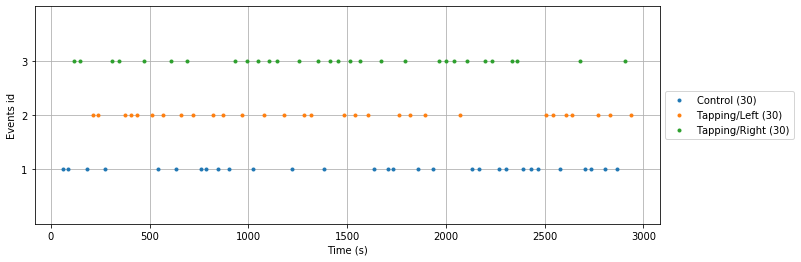

In [10]:
plt.rcParams["figure.figsize"] = (14,4)
fig = mne.viz.plot_events(events, event_id=event_dict, sfreq=raw.info['sfreq'])
fig.subplots_adjust(right=0.7)  # make room for the legend

In [11]:
reject_criteria = dict(hbo=80e-6) 
tmin, tmax = -3, 18

In [12]:
epochs = mne.Epochs(raw, events, event_id=event_dict, tmin=tmin, tmax=tmax,
                    reject=reject_criteria, reject_by_annotation=True,
                    proj=True, baseline=(None, 0), preload=True, detrend = 1, verbose=True);

90 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 90 events and 165 original time points ...
    Rejecting  epoch based on HBO : ['S4-D4 hbo']
    Rejecting  epoch based on HBO : ['S4-D4 hbo', 'S8-D8 hbo']
    Rejecting  epoch based on HBO : ['S4-D4 hbo']
    Rejecting  epoch based on HBO : ['S4-D4 hbo', 'S8-D8 hbo']
    Rejecting  epoch based on HBO : ['S4-D4 hbo', 'S6-D8 hbo', 'S8-D8 hbo']
    Rejecting  epoch based on HBO : ['S1-D1 hbo', 'S7-D7 hbo']
    Rejecting  epoch based on HBO : ['S4-D4 hbo']
    Rejecting  epoch based on HBO : ['S4-D4 hbo']
    Rejecting  epoch based on HBO : ['S4-D4 hbo', 'S6-D8 hbo', 'S8-D8 hbo']
9 bad epochs dropped


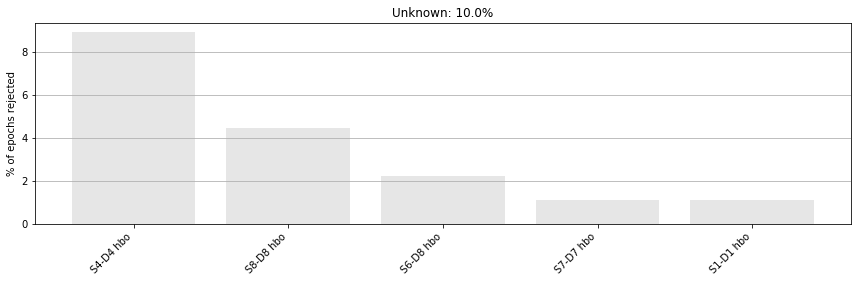

In [13]:
plt.rcParams["figure.figsize"] = (12,4)
epochs.plot_drop_log();

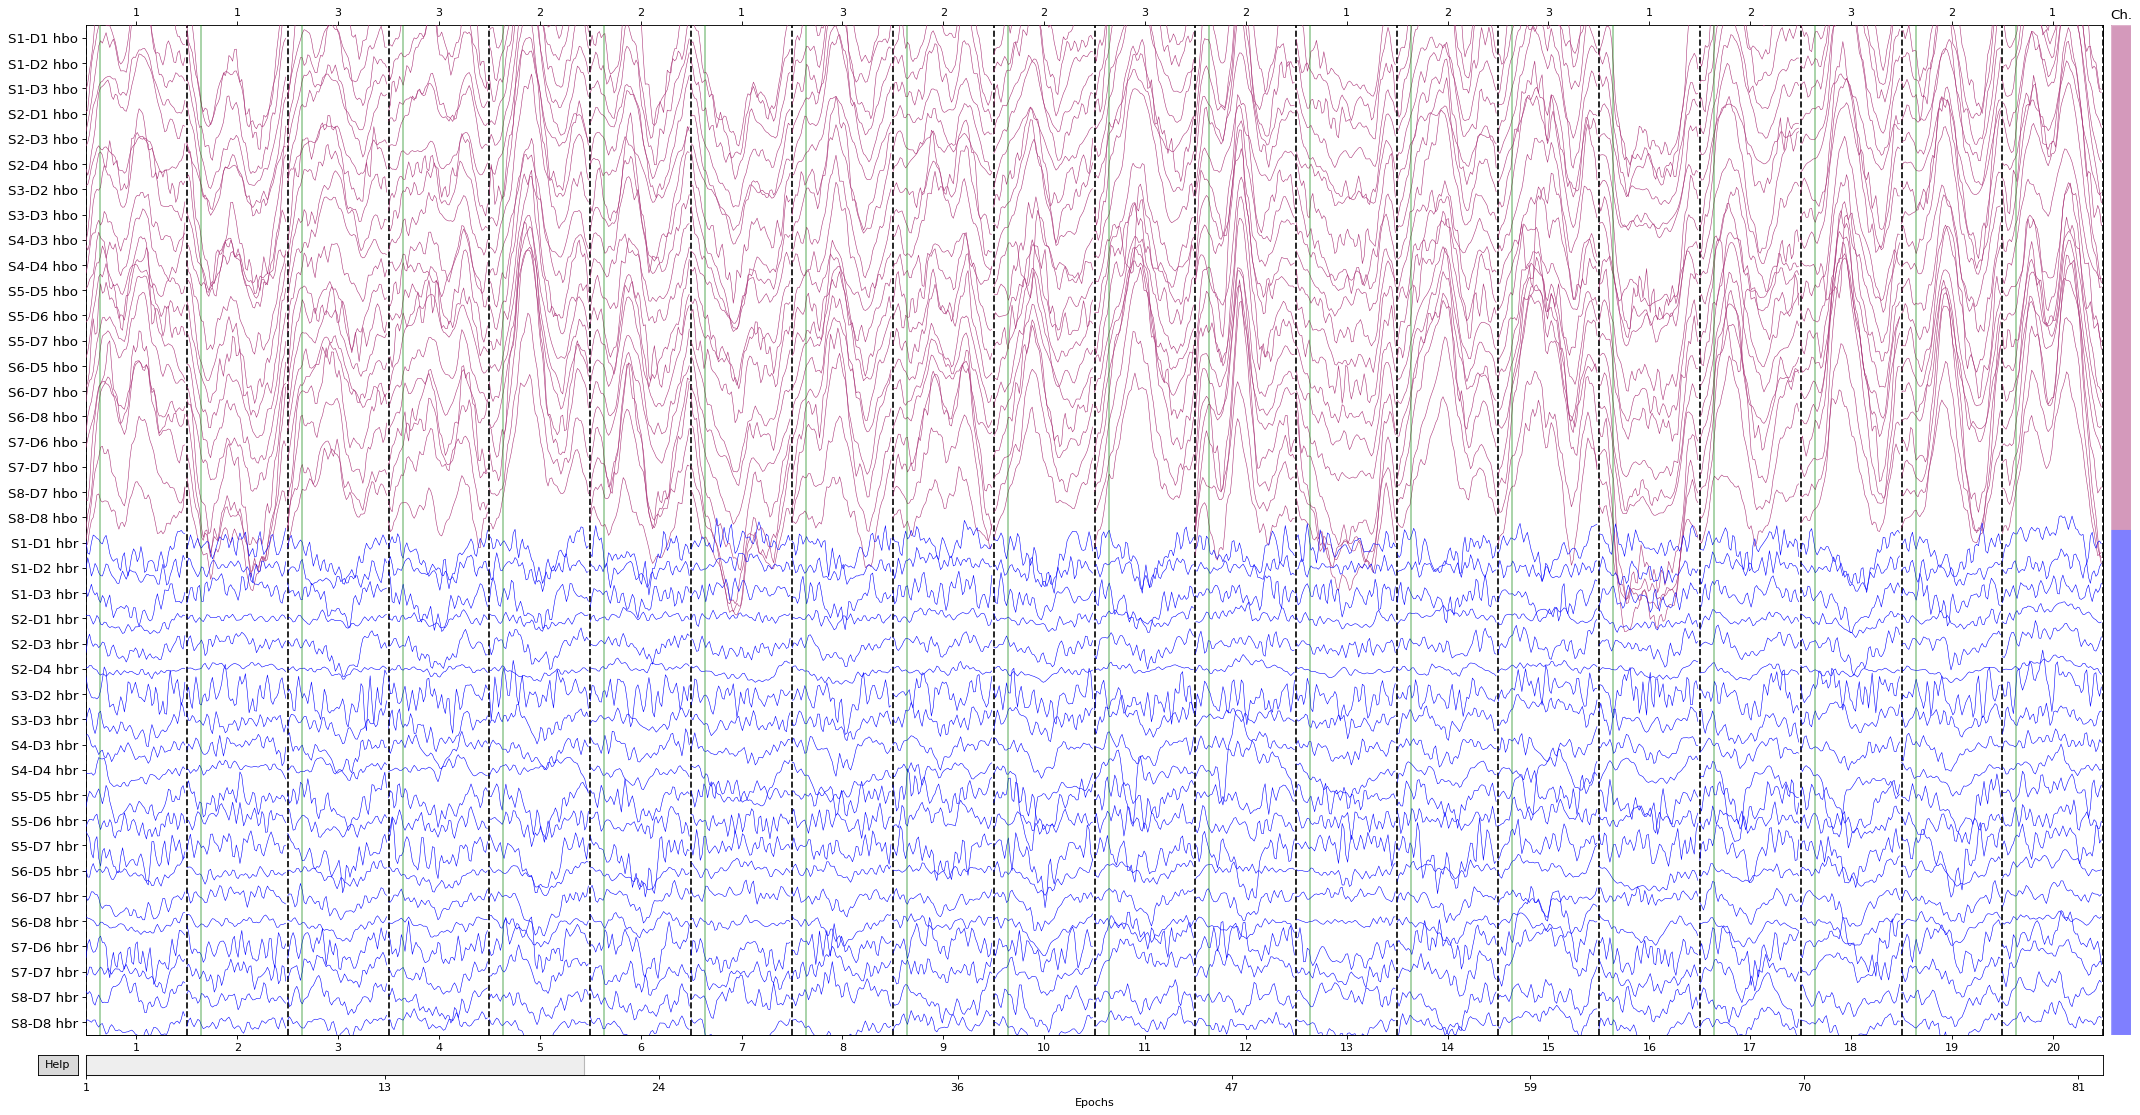

In [14]:
epochs.plot(block=True, n_channels = len(raw.ch_names));

53 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
53 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
combining channels using "mean"
combining channels using "mean"


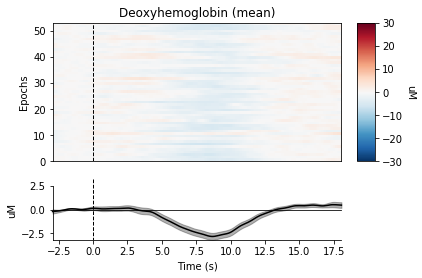

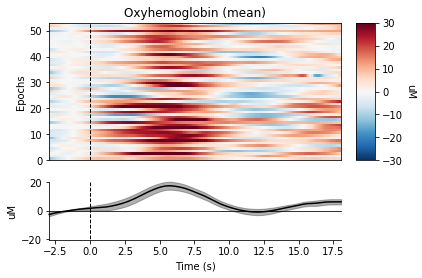

28 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
28 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
combining channels using "mean"
combining channels using "mean"


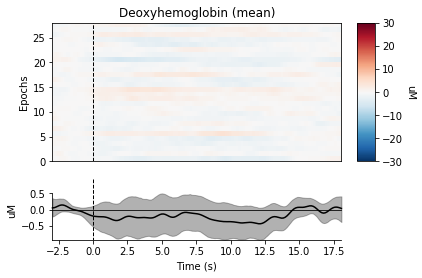

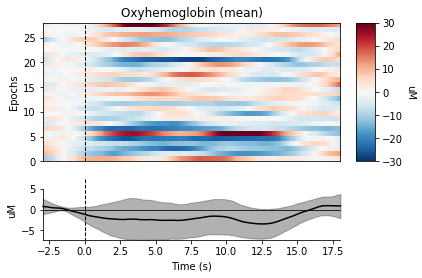

[<Figure size 432x288 with 3 Axes>, <Figure size 432x288 with 3 Axes>]

In [15]:
# How can I combine these plots so the tapping and control are side by side?
plt.rcParams["figure.figsize"] = (6,4)

epochs['Tapping'].plot_image(combine = 'mean', vmin = -30, vmax = 30)
epochs['Control'].plot_image(combine = 'mean', vmin = -30, vmax = 30)

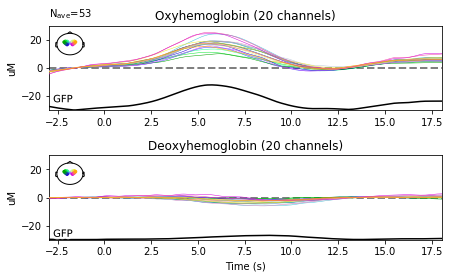

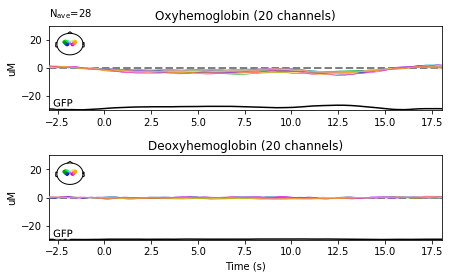

In [16]:
plt.rcParams["figure.figsize"] = (12,12)

epochs['Tapping'].average().plot(gfp = True, spatial_colors = True,
                                 ylim = dict(hbo=[-30, 30], hbr=[-30, 30]), 
                                 hline = [0.0]);
epochs['Control'].average().plot(gfp = True, spatial_colors = True,
                                 ylim = dict(hbo=[-30, 30], hbr=[-30, 30]), 
                                 hline = [0.0]);

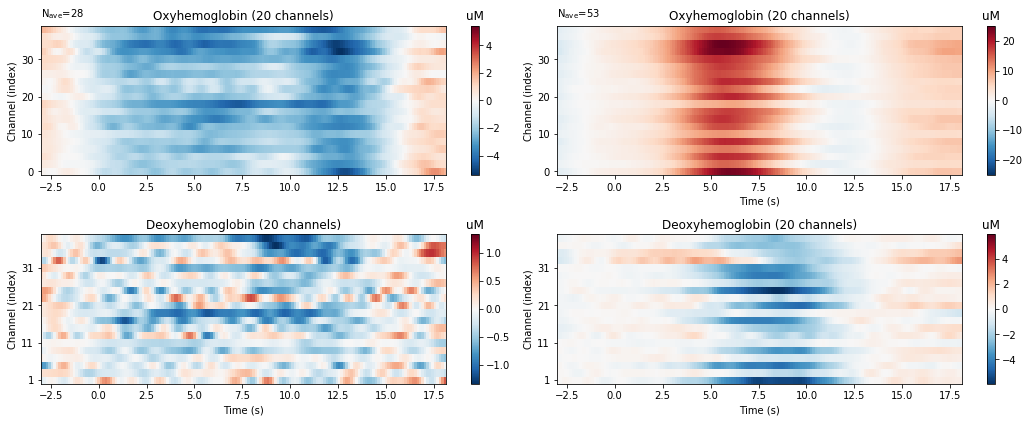

In [17]:
# How do I get these to shace a colorbar scale?
fig, (cont, tapping) = plt.subplots(nrows = 2, ncols=2, figsize=(15, 6))
epochs['Control'].average().plot_image(axes=[cont[0], tapping[0]], show=False);
epochs['Tapping'].average().plot_image(axes=[cont[1], tapping[1]], show=False);